In [88]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

sns.set_theme(style = "darkgrid")
plt.rcParams["text.usetex"] = True
plt.rcParams['figure.figsize'] = 15,8

In [104]:
def loadAndPrepData(path: str) -> pd.DataFrame:
    # Read Data
    data = pd.read_json(path, lines = True)
    
    print("Loaded -> Now extracting OPT-Values")

    # Extract OPT-Values for every Line
    val_na = []
    val_ll = []
    val_is = []
    val_it = []
    val_op = []

    for _, row in data.iterrows():
        if row["algo"] == "OPT":
            val_na.append(row["na"])
            val_ll.append(row["l"])
            val_is.append(row["ins_id"])
            val_it.append(row["iter_id"])
            val_op.append(row["val"])

    opt_data = pd.DataFrame.from_dict({
        "na": val_na,
        "l": val_ll,
        "ins_id": val_is,
        "iter_id": val_it,
        "opt": val_op
    })

    data = data.merge(opt_data, on = ["na", "l", "ins_id", "iter_id"])

    # Group Algorithms by k and l
    data["kk"] = (data["k"] * 4) / data["na"]
    data["ll"] = (data["l"] * 4) / data["k"]

    data[["kk", "ll"]] = data[["kk", "ll"]].astype(int)

    # Evaluate Algorithms
    data["approx"] = data["val"] / data["opt"]

    return data

def goalToFunction(goal: str) -> str:
    if "MAX" in goal:
        return r'$f_{max}$'
    elif "SUM" in goal:
        return r'$f_{sum}$'
    else:
        return r'$f_{cov}$'

def getGoalAlgo(row):
    if row["goal"] == "MAX":
        goal = r'\textsc{Max}'
    elif row["goal"] == "SUM":
        goal = r'\textsc{Sum}'
    else:
        goal = r'\textsc{Cov}'

    if row["algo"] == "AMP":
        algo = r'\textsc{Amp}'
    elif row["algo"] == "NAMP":
        algo = r'\textsc{Namp}'
    else:
        algo = r'None'
    
    return goal + " - " + algo

def plotData(data: pd.DataFrame, is_uniform: bool, outpath: str):
    # Plot Data
    fig, ax = plt.subplots(3, 4, sharex = True, sharey = True)

    for k in range(3):
        for l in range(4):
            plot = sns.lineplot(ax = ax[k, l], data = data[(data.kk == (k + 1)) & (data.ll == (l + 1)) & (data.algo != "OPT") & (data.algo != "EXT")], x = "na", y = "approx", hue = "algo")
            if k != 2 or l != 3:
                plot.get_legend().remove()
            else:
                plt.setp(plot.get_legend().get_texts(), fontsize = 17)
                plot.get_legend().set_title("Algorithm")

    ax[0][0].set_title(r'$\ell = \frac{1}{4}k$', fontsize = 17)
    ax[0][1].set_title(r'$\ell = \frac{2}{4}k$', fontsize = 17)
    ax[0][2].set_title(r'$\ell = \frac{3}{4}k$', fontsize = 17)
    ax[0][3].set_title(r'$\ell = \frac{4}{4}k$', fontsize = 17)

    ax[2][0].set_xlabel("")
    ax[2][1].set_xlabel("")
    ax[2][2].set_xlabel("")
    ax[2][3].set_xlabel("")

    ax[0][0].set_ylabel(r'$k = \frac{1}{4}n_A$', fontsize = 17)
    ax[1][0].set_ylabel(r'$k = \frac{2}{4}n_A$', fontsize = 17)
    ax[2][0].set_ylabel(r'$k = \frac{3}{4}n_A$', fontsize = 17)

    if is_uniform:
        fig.suptitle(goalToFunction(data["goal"].iloc[0]) + r' : $n_A = n_B = |\mathcal{V}| = 16 \cdot z$', fontsize = 23, y = 0.97)
    else:
        fig.suptitle(goalToFunction(data["goal"].iloc[0]) + r' : $n_A = 16 \cdot z,\, n_B = 400 \cdot z,\, |\mathcal{V}| = 10$', fontsize = 23, y = 0.97)

    fig.text(0.5, 0.04, r'$n_{\mathcal{A}}$', ha = "center", fontsize = 20)
    fig.text(0.04, 0.5, r'$val_{ALG} / val_{OPT}$', va = "center", rotation = "vertical", fontsize = 20)

    if outpath is not None:
        plt.savefig(outpath, format = "pdf", bbox_inches = "tight")
    plt.show()

def plotMultipleData(data: [pd.DataFrame, pd.DataFrame, pd.DataFrame], is_uniform: bool, outpath: str):
    data = pd.concat(data)
    data["goalalgo"] = data.apply(getGoalAlgo, axis = 1)

    # Plot Data
    fig, ax = plt.subplots(3, 4, sharex = True, sharey = True)

    for k in range(3):
        for l in range(4):
            plot = sns.lineplot(
                ax = ax[k, l], 
                data = data[(data.kk == (k + 1)) & (data.ll == (l + 1)) & (data.algo != "OPT") & (data.algo != "EXT")], 
                x = "na", 
                y = "approx", 
                hue = "goalalgo"
            )
            if k != 2 or l != 0:
                plot.get_legend().remove()
            else:
                ax[2][0].legend(
                    title = r'\textsc{Goal \& Algorithm}', 
                    fontsize = "15", 
                    title_fontsize = "17",
                    bbox_to_anchor = (-0.2, -0.35),
                    loc = "upper left",
                    borderaxespad = 0,
                    ncol = 6
                )

    ax[0][0].set_title(r'$\ell = \frac{1}{4}k$', fontsize = 22)
    ax[0][1].set_title(r'$\ell = \frac{2}{4}k$', fontsize = 22)
    ax[0][2].set_title(r'$\ell = \frac{3}{4}k$', fontsize = 22)
    ax[0][3].set_title(r'$\ell = \frac{4}{4}k$', fontsize = 22)

    ax[2][0].set_xlabel("")
    ax[2][1].set_xlabel("")
    ax[2][2].set_xlabel("")
    ax[2][3].set_xlabel("")

    ax[0][0].set_ylabel(r'$k = \frac{1}{4}n_A$', fontsize = 22)
    ax[1][0].set_ylabel(r'$k = \frac{2}{4}n_A$', fontsize = 22)
    ax[2][0].set_ylabel(r'$k = \frac{3}{4}n_A$', fontsize = 22)

    ax[2][0].tick_params(axis = "x", labelsize = 18)
    ax[2][1].tick_params(axis = "x", labelsize = 18)
    ax[2][2].tick_params(axis = "x", labelsize = 18)
    ax[2][3].tick_params(axis = "x", labelsize = 18)

    ax[0][0].tick_params(axis = "y", labelsize = 18)
    ax[1][0].tick_params(axis = "y", labelsize = 18)
    ax[2][0].tick_params(axis = "y", labelsize = 18)

    if is_uniform:
        fig.suptitle(r'\textsc{Uniform} : $n_A = n_B = |\mathcal{V}| = 16 \cdot z$', fontsize = 30, y = 1.0)
    else:
        fig.suptitle(r'\textsc{Network} : $n_A = 16 \cdot z,\, n_B = 400 \cdot z,\, |\mathcal{V}| = 10$', fontsize = 30, y = 1.0)

    fig.text(0.52, 0.06, r'$n_{\mathcal{A}}$', ha = "center", fontsize = 25)
    fig.text(0.025, 0.5, r'$val_{ALG} / val_{OPT}$', va = "center", rotation = "vertical", fontsize = 25)

    if outpath is not None:
        plt.savefig(outpath, format = "pdf", bbox_inches = "tight")
    plt.show()

# Uniform Max

In [3]:
uniform_max_data = loadAndPrepData("../data/MAX_UNIFORM.json")

Loaded -> Now extracting OPT-Values


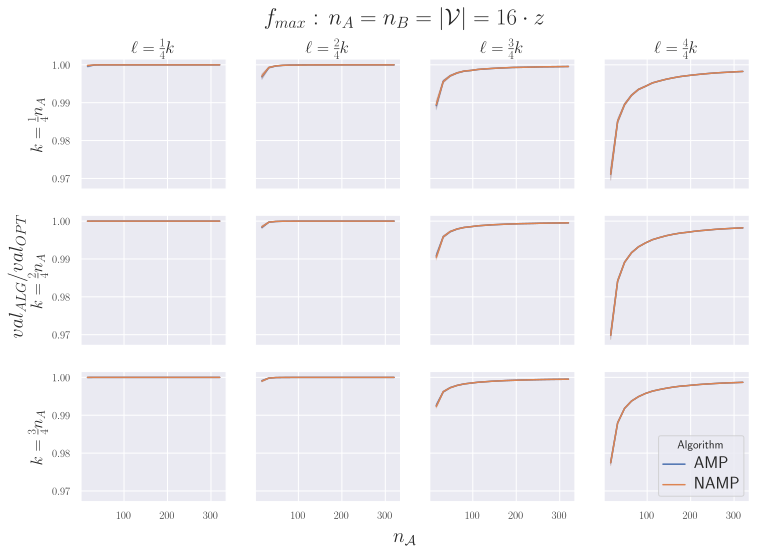

In [17]:
plotData(uniform_max_data, True, "../img/MAX_UNIFORM.pdf")

# Uniform Sum

In [19]:
uniform_sum_data = loadAndPrepData("../data/SUM_UNIFORM.json")

Loaded -> Now extracting OPT-Values


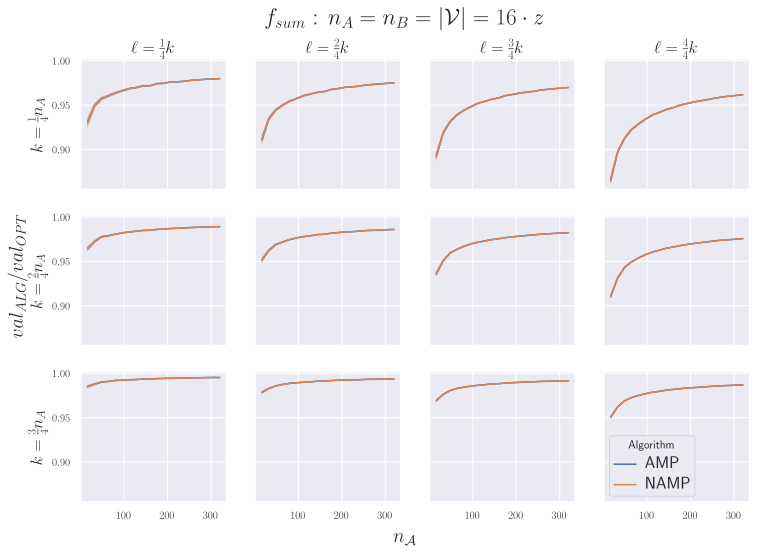

In [13]:
plotData(uniform_sum_data, True)

# Uniform Cov

In [20]:
uniform_cov_data = loadAndPrepData("../data/COV_UNIFORM.json")

Loaded -> Now extracting OPT-Values


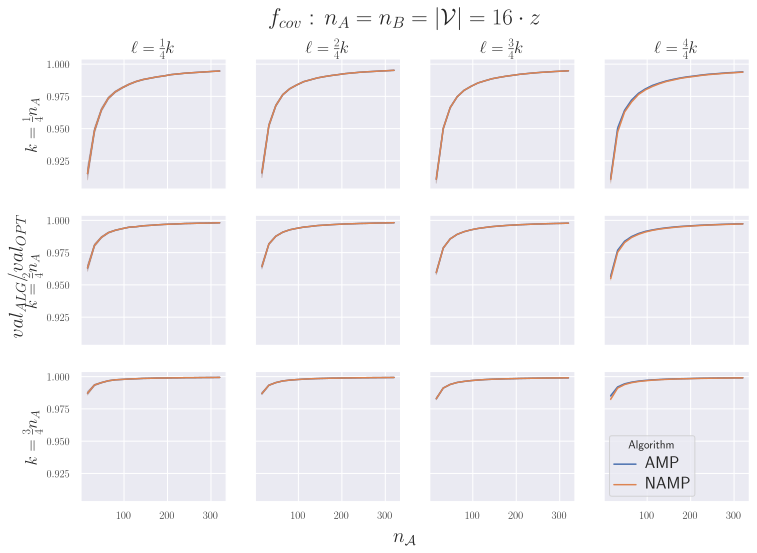

In [15]:
plotData(uniform_cov_data, True)

# Complete Uniform Data

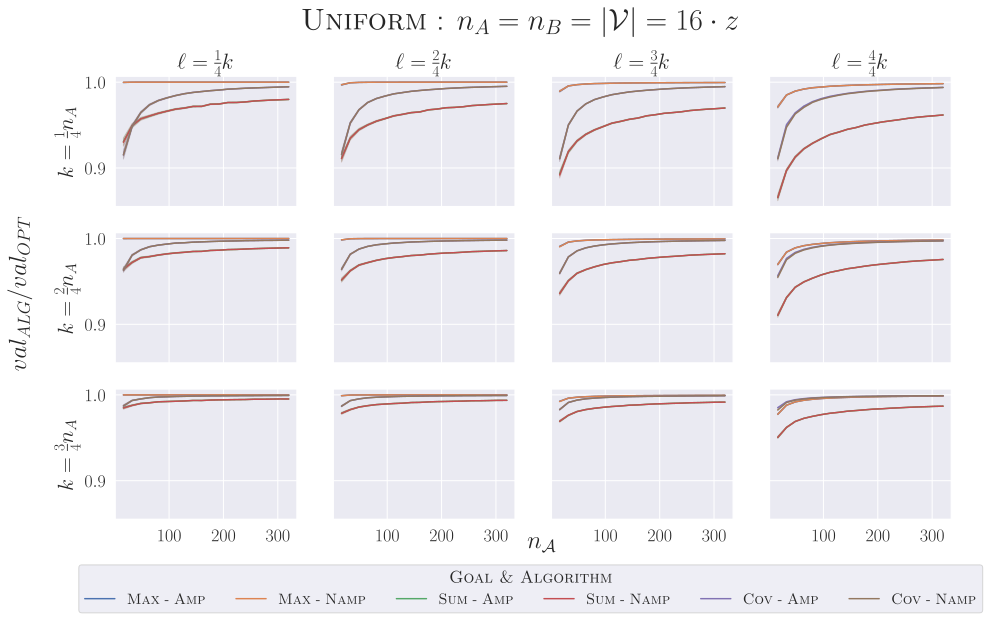

In [105]:
plotMultipleData([uniform_max_data, uniform_sum_data, uniform_cov_data], True, "../img/UNIFORM.pdf")

# Network Max

In [100]:
network_max_data = loadAndPrepData("../data/MAX_NETWORK.json")

Loaded -> Now extracting OPT-Values


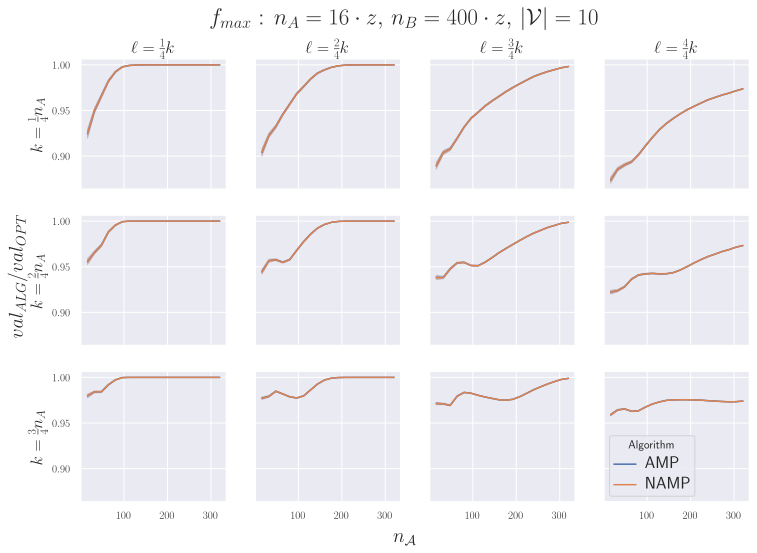

In [17]:
plotData(network_max_data, False)

# Network Sum

In [101]:
network_sum_data = loadAndPrepData("../data/SUM_NETWORK.json")

Loaded -> Now extracting OPT-Values


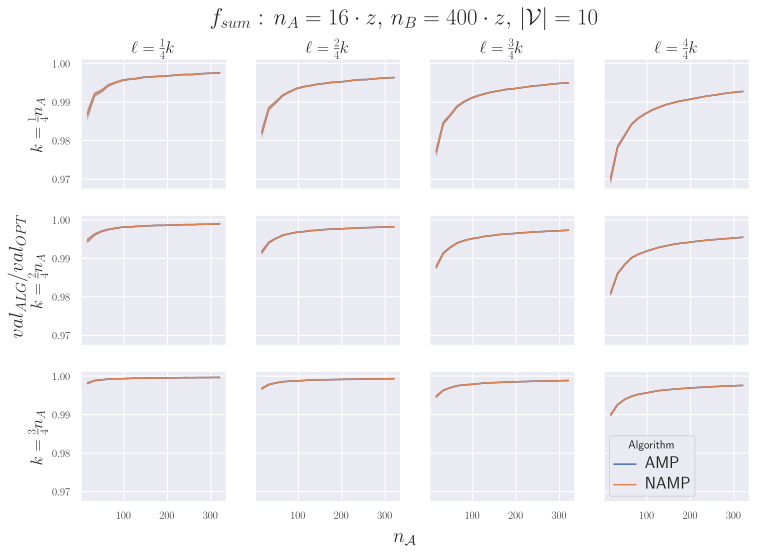

In [19]:
plotData(network_sum_data, False)

# Network Cov

In [102]:
network_cov_data = loadAndPrepData("../data/COV_NETWORK.json")

Loaded -> Now extracting OPT-Values


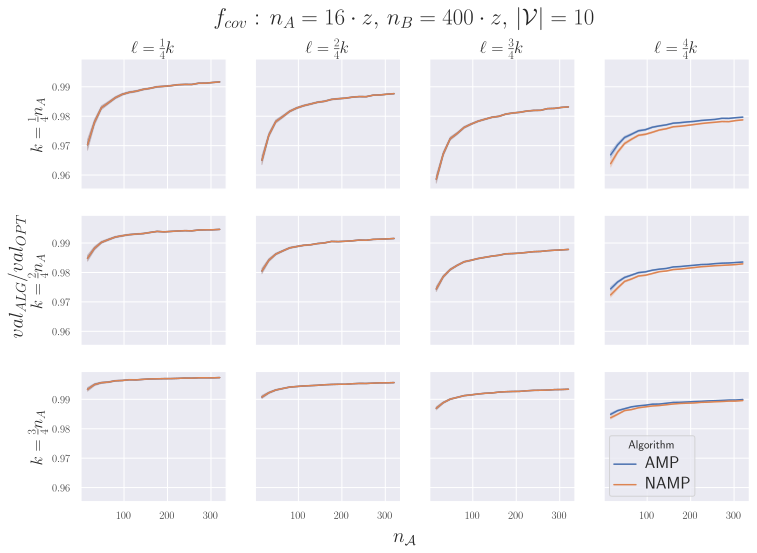

In [4]:
plotData(network_cov_data, False)

# Complete Network Data

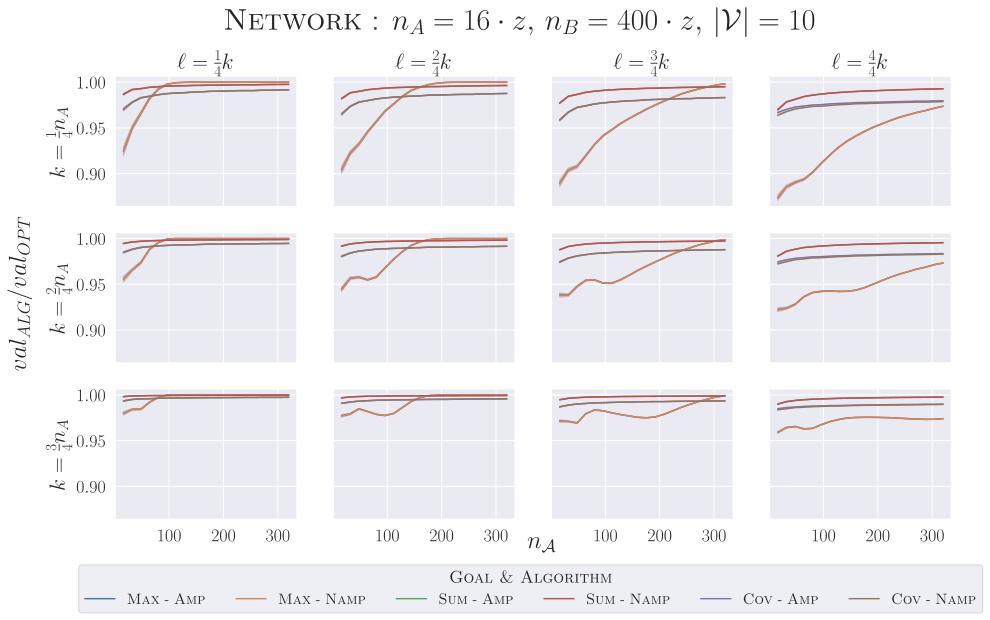

In [106]:
plotMultipleData([network_max_data, network_sum_data, network_cov_data], False, "../img/NETWORK.pdf")

In [54]:
def loadAndPrepTimeData(uniform_path: str, network_path: str) -> pd.DataFrame:
    uniform_data = pd.read_json(uniform_path, lines = True)
    network_data = pd.read_json(network_path, lines = True)

    uniform_data["setting"] = uniform_data["algo"] + " - Uniform"
    network_data["setting"] = network_data["algo"] + " - Network"

    data = pd.concat([uniform_data, network_data], ignore_index = True, sort = False)

    # Group Algorithms by k and l
    data["kk"] = (data["k"] * 4) / data["na"]
    data["ll"] = (data["l"] * 4) / data["k"]

    data[["kk", "ll"]] = data[["kk", "ll"]].astype(int)

    return data


def plotTimeData(data: pd.DataFrame):
    # Plot Data
    fig, ax = plt.subplots(3, 4, sharex = True, sharey = True)

    for k in range(3):
        for l in range(4):
            plot = sns.lineplot(ax = ax[k, l], data = data[(data.kk == (k + 1)) & (data.ll == (l + 1)) & (data.algo != "EXT")], x = "na", y = "time", hue = "setting")
            if k != 1 or l != 3:
                plot.get_legend().remove()
            else:
                plt.setp(plot.get_legend().get_texts(), fontsize = 20)
                plot.get_legend().set_title("Algorithm \& Setting")
                sns.move_legend(plot, "center left", bbox_to_anchor=(1.0, 0.5))

    ax[0][0].set_title(r'$\ell = \frac{1}{4}k$', fontsize = 17)
    ax[0][1].set_title(r'$\ell = \frac{2}{4}k$', fontsize = 17)
    ax[0][2].set_title(r'$\ell = \frac{3}{4}k$', fontsize = 17)
    ax[0][3].set_title(r'$\ell = \frac{4}{4}k$', fontsize = 17)

    ax[2][0].set_xlabel("")
    ax[2][1].set_xlabel("")
    ax[2][2].set_xlabel("")
    ax[2][3].set_xlabel("")

    ax[0][0].set_ylabel(r'$k = \frac{1}{4}n_A$', fontsize = 17)
    ax[1][0].set_ylabel(r'$k = \frac{2}{4}n_A$', fontsize = 17)
    ax[2][0].set_ylabel(r'$k = \frac{3}{4}n_A$', fontsize = 17)

    fig.suptitle(goalToFunction(data["goal"].iloc[0]) + r': execution time of algorithms', fontsize = 20, y = 0.97)

    fig.text(0.5, 0.04, r'$n_{\mathcal{A}}$', ha = "center", fontsize = 20)
    fig.text(0.04, 0.5, r'time in $s$', va = "center", rotation = "vertical", fontsize = 20)

    plt.yscale("log")

    plt.show()

# Max Time

In [8]:
time_max_data = loadAndPrepTimeData("../data/MAX_UNIFORM.json", "../data/MAX_NETWORK.json")

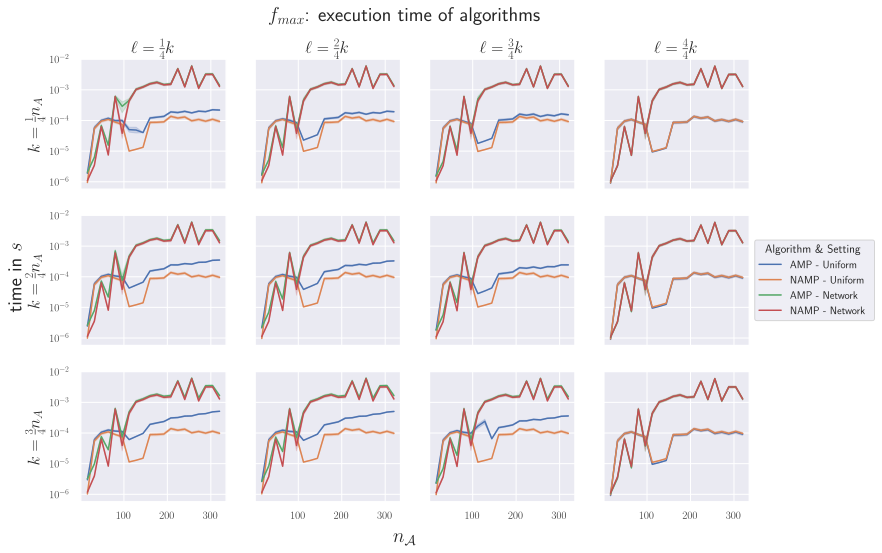

In [55]:
plotTimeData(time_max_data)

# Sum Time

In [21]:
time_sum_data = loadAndPrepTimeData("../data/SUM_UNIFORM.json", "../data/SUM_NETWORK.json")

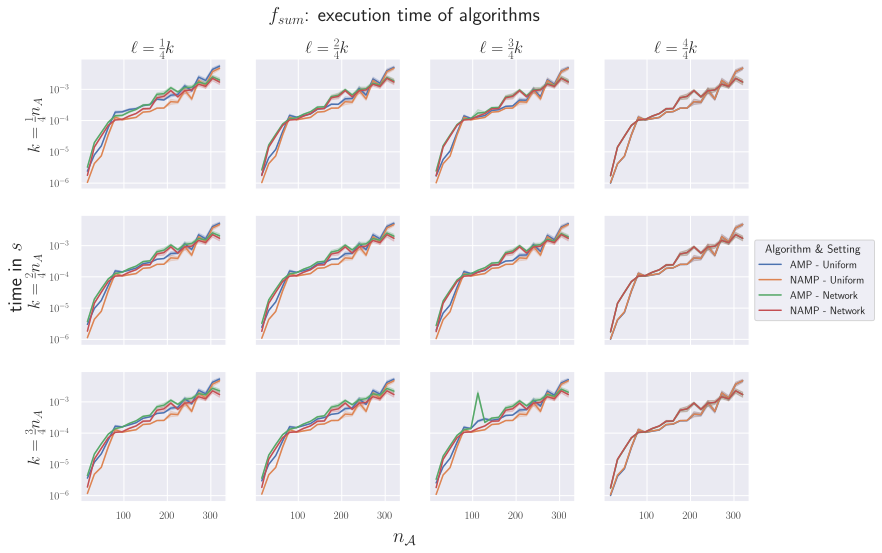

In [56]:
plotTimeData(time_sum_data)

# Cov Time

In [23]:
time_cov_data = loadAndPrepTimeData("../data/COV_UNIFORM.json", "../data/COV_NETWORK.json")

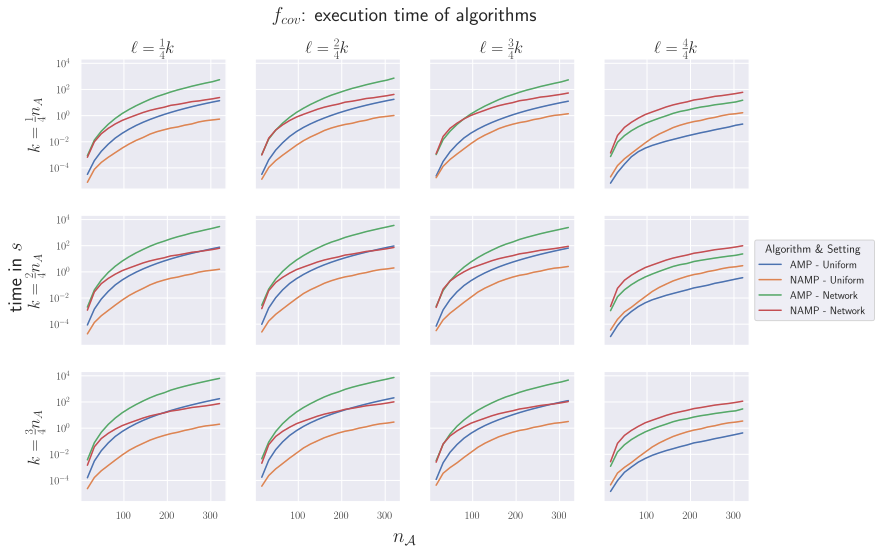

In [57]:
plotTimeData(time_cov_data)